### Regression Exercise 
# Moneyball The NBA
---

# Rough Guide a v1 model.
0. Make a model to predict PTS 
0. For v1, dont use `2P, 3P, FG, or FT`.  Instead use `2PA, 3PA, FTA`.  
0. Include any other cols use see fit.  


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import CTPLIB as ctp

In [33]:
df = pd.read_csv('data/NBA_train.csv')
df.dropna(inplace=True)

<Axes: xlabel='W', ylabel='Playoffs'>

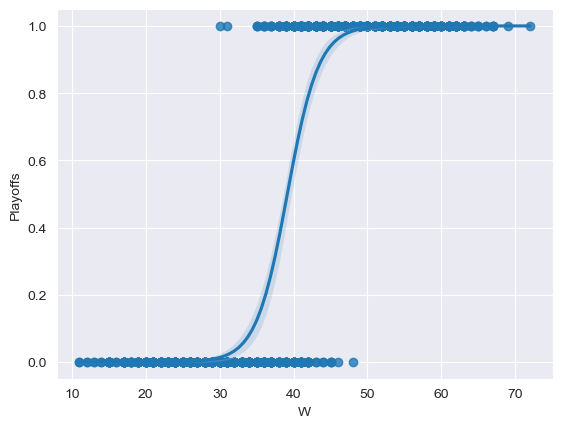

In [34]:
sns.regplot(data=df, x="W", y="Playoffs", logistic=True)

Let Y represent the event of a team making the playoffs. The expression P(Y | W) represents the likelihood a team making the playoffs given W wins.

The bottom and top horizontal lines represent:
- Teams that did not make the playoffs P(Y | W) = 0
- Teams that did make the playoffs P(Y | W) = 1

The logistic regression curve shows that the playoff probability increases exponentially at P(Y | W >= 30) and reaches near certainty at P(Y | W >= 50).